In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch


In [160]:
#バンディット環境の実装

#報酬オブジェクト
class Reward:
    def __init__(self,value:float):
        self.value = value

    def value (self):
        return self.value
    
#アームオブジェクト
class Arm:
    def pull(self):
        raise NotImplementedError("pull() is not implemented")

#二項分布を報酬の分布とするアーム
class BernoulliArm(Arm):
    def __init__(self, p:float):
        self.p = p

    def pull(self):
        return np.random.binomial(1, self.p)

#正規分布を報酬の分布とするアーム
class NormalArm(Arm):
    def __init__(self,mu:float,sigma:float):
        self.mu = mu
        self.sigma = sigma
    
    def pull(self):
        return np.random.normal(self.mu,self.sigma)

arm_1 = BernoulliArm(0.3)
arm_2 = BernoulliArm(0.5)
arm_3 = BernoulliArm(0.55)
arms = [arm_1,arm_2,arm_3]

#バンディット環境
class BanditEnv:
    def __init__(self,arms):
        self.arms = arms

    def step(self,arm):
        return self.arms[arm].pull()
    

env = BanditEnv(arms)


ETCを実装するために，あるアーム$i$が$t$ラウンド後に得られる平均報酬を以下のように定義します．Pythonで実装してみましょう．

$\hat{\mu}_i(t)=\frac{1}{T_i(t)} \sum_{s=1}^t \mathbb{I}\left\{A_s=i\right\} X_s$

なお，$T_i(t)=\sum_{s=1}^t \mathbb{I}\left\{A_s=i\right\}$，$\mathbb{I}\left\{A_s=i\right\}$はあるタイムステップ$s$で選んだアームが$i$ならば$1$を出力し，それ以外は$0$を出力する関数です．

また，ETCアルゴリズムにおける方策は以下のように設計されます．

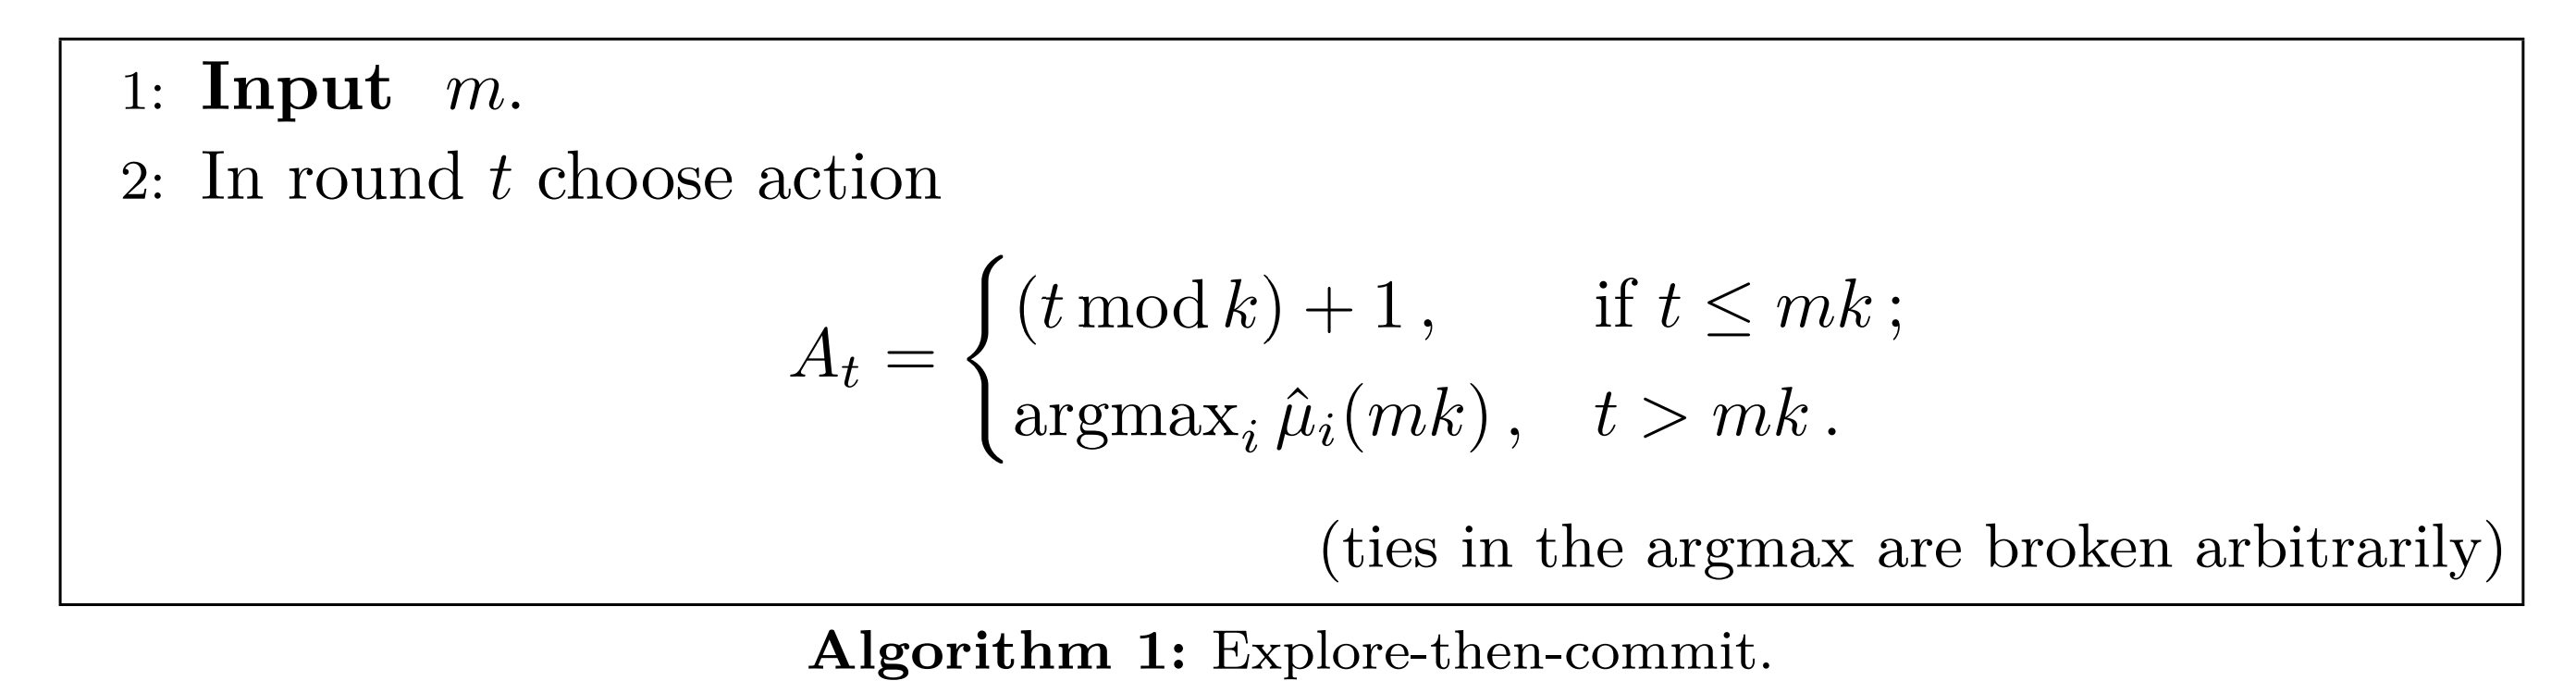

In [161]:
class ETC_Algorithm:
    def __init__(self,k:int,m:int):
        #現在のラウンド数
        self.t = 0
        #アームの数
        self.k = k
        #各アームの探索上限回数
        self.m = m
        #アームの番号kと報酬rをt次元記録する配列
        self.selected_arm_array = np.zeros(m * k)
        self.reward_array = np.zeros(m * k)
        self.counter = 0
    
    #アームiがtラウンド後に得られる平均報酬
    def calc_mu(self):
        mus = np.zeros(self.k)
        for i in range(self.k):
            T = np.count_nonzero(self.selected_arm_array == i)

            selected_indices = np.where(self.selected_arm_array == i)
            rewards = self.reward_array[selected_indices]
            avg_reward = np.sum(rewards)
            mus[i] = (avg_reward / T)
        return mus

    def policy(self):
        if self.t <= self.m * self.k:
            #(t mod k) + 1を返す    
            return self.t % self.k 
        else:
            mus = self.calc_mu()
            return np.argmax(mus) 
        
ETC = ETC_Algorithm(3,10)

#mk回の探索を行う

for i in  range(ETC.m * ETC.k):
    arm = ETC.policy()
    reward = env.step(arm)
    ETC.selected_arm_array[i] = arm
    ETC.reward_array[i] = reward
    ETC.t += 1   

#各アームの平均報酬を計算

#30回の活用を行う
for i in range(30):
    arm = ETC.policy()
    reward = env.step(arm)
    ETC.selected_arm_array[i] = arm
    ETC.reward_array[i] = reward
    ETC.t += 1



/tmp/ipykernel_271076/1760811061.py:23: RuntimeWarning: invalid value encountered in double_scalars
  mus[i] = (avg_reward / T)


/tmp/ipykernel_271076/1760811061.py:23: RuntimeWarning: invalid value encountered in double_scalars
  mus[i] = (avg_reward / T)


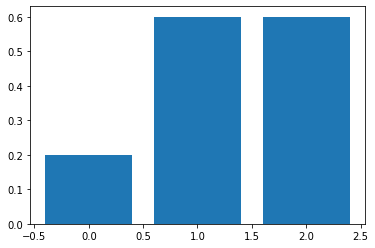

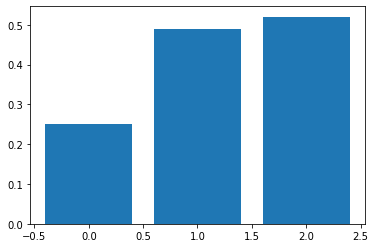

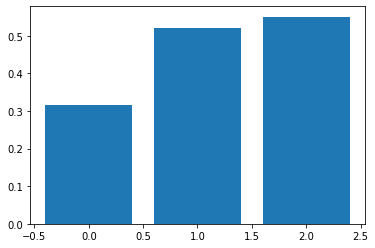

In [165]:
#各探索回数ごとに得られた最も高いアームを選び続けることで得られる平均報酬の推移をプロット
ms = [10,100,1000,10000]
ETC_10 = ETC_Algorithm(3,10)
ETC_100 = ETC_Algorithm(3,100)
ETC_1000 = ETC_Algorithm(3,1000)
ETCs = [ETC_10,ETC_100,ETC_1000]
mu_list = []
for i,ETC in enumerate(ETCs):
    for j in range(ETC.m * ETC.k):
        arm = ETC.policy()
        reward = env.step(arm)
        ETC.selected_arm_array[j] = arm
        ETC.reward_array[j] = reward
        ETC.t += 1
    mus = ETC.calc_mu()
    for j in range(ETC.m * ETC.k):
        arm = ETC.policy()
        reward = env.step(arm)
        ETC.selected_arm_array[j] = arm
        ETC.reward_array[j] = reward
        ETC.t += 1
    mu_list.append(mus)

#mu_list[i]を棒グラフでプロット
for i in range(len(mu_list)):
    plt.bar([0,1,2],mu_list[i])
    plt.show()
   
    